In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
# load Dataset
from datasets import load_dataset
dataset = load_dataset("blanchon/EuroSAT_RGB")

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake'], id=None),
 'filename': Value(dtype='string', id=None)}

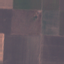

In [ ]:
example = dataset["train"][0]
example["image"]

In [ ]:
labels = dataset["train"].features["label"].names
print(labels)

['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']


In [ ]:
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'Annual Crop', 1: 'Forest', 2: 'Herbaceous Vegetation', 3: 'Highway', 4: 'Industrial Buildings', 5: 'Pasture', 6: 'Permanent Crop', 7: 'Residential Buildings', 8: 'River', 9: 'SeaLake'}


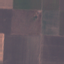

In [ ]:
dataset["train"][0]["image"]

# PreTrain

In [ ]:
from transformers import ConvNextFeatureExtractor

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

In [ ]:
target_size = (224, 224)
transform = Compose(
    [
     RandomResizedCrop(target_size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

In [ ]:
def train_transforms(examples):
  examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]

  return examples

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

In [ ]:
processed_dataset = dataset.with_transform(train_transforms)

In [ ]:

processed_dataset["train"][0]["pixel_values"].shape

torch.Size([3, 224, 224])

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/114M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [ ]:
device

'cuda'

In [ ]:
processed_dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'label': 0,
 'filename': 'AnnualCrop_1.tif',
 'pixel_values': tensor([[[-0.6281, -0.6281, -0.6281,  ..., -0.5596, -0.5596, -0.5596],
          [-0.6281, -0.6281, -0.6281,  ..., -0.5596, -0.5596, -0.5596],
          [-0.6281, -0.6281, -0.6281,  ..., -0.5596, -0.5596, -0.5596],
          ...,
          [-0.5424, -0.5424, -0.5424,  ..., -0.6281, -0.6281, -0.6281],
          [-0.5424, -0.5424, -0.5424,  ..., -0.6281, -0.6281, -0.6281],
          [-0.5424, -0.5424, -0.5424,  ..., -0.6281, -0.6281, -0.6281]],
 
         [[-0.6527, -0.6527, -0.6527,  ..., -0.4776, -0.4776, -0.4776],
          [-0.6527, -0.6527, -0.6527,  ..., -0.4776, -0.4776, -0.4776],
          [-0.6527, -0.6527, -0.6527,  ..., -0.4776, -0.4776, -0.4776],
          ...,
          [-0.5651, -0.5651, -0.5651,  ..., -0.6352, -0.6352, -0.6352],
          [-0.5651, -0.5651, -0.5651,  ..., -0.6352, -0.6352, -0.6352],
          [-0.5651, -0.5651, -0.5651,  ...

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(examples):
  pixel_values = torch.stack([example["pixel_values"] for example in examples])
  labels = torch.tensor([example["label"] for example in examples])

  return {"pixel_values": pixel_values, "labels": labels}

dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=4, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Model training

In [ ]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):
  print("Epoch:", epoch)
  correct = 0
  total = 0
  for idx, batch in enumerate(tqdm(dataloader)):
    # move batch to GPU
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    # forward pass
    outputs = model(pixel_values=batch["pixel_values"],
                    labels=batch["labels"])

    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    optimizer.step()

    # metrics
    total += batch["labels"].shape[0]
    predicted = logits.argmax(-1)
    correct += (predicted == batch["labels"]).sum().item()

    accuracy = correct/total

    if idx % 100 == 0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

Epoch: 0


  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 2.3019859790802
Accuracy after 0 steps: 0.0
Loss after 100 steps: 1.5006855726242065
Accuracy after 100 steps: 0.48514851485148514
Loss after 200 steps: 0.9068602323532104
Accuracy after 200 steps: 0.6119402985074627
Loss after 300 steps: 0.9519710540771484
Accuracy after 300 steps: 0.6802325581395349
Loss after 400 steps: 0.4036253094673157
Accuracy after 400 steps: 0.7194513715710723
Loss after 500 steps: 1.412662148475647
Accuracy after 500 steps: 0.75
Loss after 600 steps: 0.04324231296777725
Accuracy after 600 steps: 0.7724625623960066
Loss after 700 steps: 0.135928213596344
Accuracy after 700 steps: 0.7917261055634808
Loss after 800 steps: 0.05800490826368332
Accuracy after 800 steps: 0.8049313358302123
Loss after 900 steps: 1.0449936389923096
Accuracy after 900 steps: 0.8171476137624861
Loss after 1000 steps: 0.9273136258125305
Accuracy after 1000 steps: 0.8286713286713286
Loss after 1100 steps: 0.10144979506731033
Accuracy after 1100 steps: 0.836512261580381

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.012583799660205841
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.006943116895854473
Accuracy after 100 steps: 0.9232673267326733
Loss after 200 steps: 0.323231041431427
Accuracy after 200 steps: 0.9427860696517413
Loss after 300 steps: 0.1339283585548401
Accuracy after 300 steps: 0.9451827242524917
Loss after 400 steps: 0.030622534453868866
Accuracy after 400 steps: 0.9389027431421446
Loss after 500 steps: 0.012669948861002922
Accuracy after 500 steps: 0.9426147704590818
Loss after 600 steps: 1.2549941539764404
Accuracy after 600 steps: 0.9409317803660566
Loss after 700 steps: 0.018554313108325005
Accuracy after 700 steps: 0.9443651925820257
Loss after 800 steps: 0.028439141809940338
Accuracy after 800 steps: 0.9463171036204744
Loss after 900 steps: 0.05044594407081604
Accuracy after 900 steps: 0.9456159822419534
Loss after 1000 steps: 0.1499636322259903
Accuracy after 1000 steps: 0.9465534465534465
Loss after 1100 steps: 0.004632564727216959
Accuracy after 

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.05527409166097641
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.00637450348585844
Accuracy after 100 steps: 0.9603960396039604
Loss after 200 steps: 0.04448537528514862
Accuracy after 200 steps: 0.9664179104477612
Loss after 300 steps: 0.03934566304087639
Accuracy after 300 steps: 0.9617940199335548
Loss after 400 steps: 0.03532078489661217
Accuracy after 400 steps: 0.9644638403990025
Loss after 500 steps: 0.0033590495586395264
Accuracy after 500 steps: 0.9635728542914171
Loss after 600 steps: 0.14892534911632538
Accuracy after 600 steps: 0.9613144758735441
Loss after 700 steps: 0.0029494655318558216
Accuracy after 700 steps: 0.9604136947218259
Loss after 800 steps: 0.0048628440126776695
Accuracy after 800 steps: 0.9603620474406991
Loss after 900 steps: 0.004744496196508408
Accuracy after 900 steps: 0.9611542730299667
Loss after 1000 steps: 0.015156921930611134
Accuracy after 1000 steps: 0.9600399600399601
Loss after 1100 steps: 0.3619609475135803
Accuracy a

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.009364095516502857
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.18308226764202118
Accuracy after 100 steps: 0.9678217821782178
Loss after 200 steps: 0.13978630304336548
Accuracy after 200 steps: 0.9601990049751243
Loss after 300 steps: 0.007365249563008547
Accuracy after 300 steps: 0.9642857142857143
Loss after 400 steps: 0.8303349018096924
Accuracy after 400 steps: 0.9625935162094763
Loss after 500 steps: 0.0031208775471895933
Accuracy after 500 steps: 0.9650698602794411
Loss after 600 steps: 0.9553824663162231
Accuracy after 600 steps: 0.9625623960066556
Loss after 700 steps: 0.10793918371200562
Accuracy after 700 steps: 0.9614835948644793
Loss after 800 steps: 0.008660647086799145
Accuracy after 800 steps: 0.9616104868913857
Loss after 900 steps: 0.007958726957440376
Accuracy after 900 steps: 0.9611542730299667
Loss after 1000 steps: 0.30884307622909546
Accuracy after 1000 steps: 0.9600399600399601
Loss after 1100 steps: 0.0015421550488099456
Accuracy af

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.030774468556046486
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0019206037977710366
Accuracy after 100 steps: 0.9529702970297029
Loss after 200 steps: 1.5365750789642334
Accuracy after 200 steps: 0.9527363184079602
Loss after 300 steps: 0.0015753689222037792
Accuracy after 300 steps: 0.9526578073089701
Loss after 400 steps: 0.00804982054978609
Accuracy after 400 steps: 0.9576059850374065
Loss after 500 steps: 0.011216293089091778
Accuracy after 500 steps: 0.9615768463073853
Loss after 600 steps: 0.01010783389210701
Accuracy after 600 steps: 0.9629783693843594
Loss after 700 steps: 0.05159931629896164
Accuracy after 700 steps: 0.9621968616262482
Loss after 800 steps: 0.0033168417867273092
Accuracy after 800 steps: 0.962234706616729
Loss after 900 steps: 0.5651262998580933
Accuracy after 900 steps: 0.9642064372918979
Loss after 1000 steps: 0.004615938290953636
Accuracy after 1000 steps: 0.9642857142857143
Loss after 1100 steps: 0.11220210790634155
Accuracy af

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.18445917963981628
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.005332506727427244
Accuracy after 100 steps: 0.9801980198019802
Loss after 200 steps: 0.9907397627830505
Accuracy after 200 steps: 0.9776119402985075
Loss after 300 steps: 0.048510003834962845
Accuracy after 300 steps: 0.9709302325581395
Loss after 400 steps: 0.004155669827014208
Accuracy after 400 steps: 0.9663341645885287
Loss after 500 steps: 0.03384045884013176
Accuracy after 500 steps: 0.9615768463073853
Loss after 600 steps: 0.004108518827706575
Accuracy after 600 steps: 0.9613144758735441
Loss after 700 steps: 0.01958712376654148
Accuracy after 700 steps: 0.9621968616262482
Loss after 800 steps: 0.002074431860819459
Accuracy after 800 steps: 0.964107365792759
Loss after 900 steps: 0.002546980744227767
Accuracy after 900 steps: 0.9661487236403996
Loss after 1000 steps: 0.020042069256305695
Accuracy after 1000 steps: 0.9667832167832168
Loss after 1100 steps: 0.4762018620967865
Accuracy afte

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.010916657745838165
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0005908757448196411
Accuracy after 100 steps: 0.9653465346534653
Loss after 200 steps: 0.2321254014968872
Accuracy after 200 steps: 0.9676616915422885
Loss after 300 steps: 0.09633657336235046
Accuracy after 300 steps: 0.96843853820598
Loss after 400 steps: 0.0016386075876653194
Accuracy after 400 steps: 0.9638403990024937
Loss after 500 steps: 0.06972488760948181
Accuracy after 500 steps: 0.9630738522954092
Loss after 600 steps: 0.52101069688797
Accuracy after 600 steps: 0.9638103161397671
Loss after 700 steps: 0.008667602203786373
Accuracy after 700 steps: 0.9650499286733238
Loss after 800 steps: 0.01958676055073738
Accuracy after 800 steps: 0.9662921348314607
Loss after 900 steps: 0.10243017971515656
Accuracy after 900 steps: 0.9669811320754716
Loss after 1000 steps: 0.009323975071310997
Accuracy after 1000 steps: 0.9682817182817183
Loss after 1100 steps: 0.02331444062292576
Accuracy after 1

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.005477502942085266
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.005572255235165358
Accuracy after 100 steps: 0.9678217821782178
Loss after 200 steps: 0.013870222494006157
Accuracy after 200 steps: 0.9689054726368159
Loss after 300 steps: 0.0019056512974202633
Accuracy after 300 steps: 0.9700996677740864
Loss after 400 steps: 0.00422566756606102
Accuracy after 400 steps: 0.9706982543640897
Loss after 500 steps: 0.0008552823564969003
Accuracy after 500 steps: 0.966566866267465
Loss after 600 steps: 0.017311373725533485
Accuracy after 600 steps: 0.9683860232945092
Loss after 700 steps: 0.005822790786623955
Accuracy after 700 steps: 0.9700427960057061
Loss after 800 steps: 0.09531313180923462
Accuracy after 800 steps: 0.9700374531835206
Loss after 900 steps: 0.002857317216694355
Accuracy after 900 steps: 0.9680910099889012
Loss after 1000 steps: 0.44857102632522583
Accuracy after 1000 steps: 0.9672827172827173
Loss after 1100 steps: 0.0013839438324794173
Accura

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 0.0018947366625070572
Accuracy after 0 steps: 1.0
Loss after 100 steps: 0.0006861150613985956
Accuracy after 100 steps: 0.9628712871287128
Loss after 200 steps: 0.0037611450534313917
Accuracy after 200 steps: 0.9651741293532339
Loss after 300 steps: 0.0974711999297142
Accuracy after 300 steps: 0.9692691029900332
Loss after 400 steps: 0.007339776493608952
Accuracy after 400 steps: 0.970074812967581
Loss after 500 steps: 0.0015587701927870512
Accuracy after 500 steps: 0.9725548902195609
Loss after 600 steps: 0.005564641207456589
Accuracy after 600 steps: 0.9725457570715474
Loss after 700 steps: 0.423417329788208
Accuracy after 700 steps: 0.9725392296718973
Loss after 800 steps: 0.4345735013484955
Accuracy after 800 steps: 0.9731585518102372
Loss after 900 steps: 0.025842413306236267
Accuracy after 900 steps: 0.9728079911209767
Loss after 1000 steps: 0.09045463800430298
Accuracy after 1000 steps: 0.9727772227772228
Loss after 1100 steps: 0.036287710070610046
Accuracy a

  0%|          | 0/4050 [00:00<?, ?it/s]

Loss after 0 steps: 1.621551513671875
Accuracy after 0 steps: 0.75
Loss after 100 steps: 0.4149017333984375
Accuracy after 100 steps: 0.9777227722772277
Loss after 200 steps: 0.0030536772683262825
Accuracy after 200 steps: 0.9751243781094527
Loss after 300 steps: 0.7699772715568542
Accuracy after 300 steps: 0.9700996677740864
Loss after 400 steps: 0.01704474166035652
Accuracy after 400 steps: 0.9713216957605985
Loss after 500 steps: 0.042278021574020386
Accuracy after 500 steps: 0.9735528942115769
Loss after 600 steps: 0.0008260880131274462
Accuracy after 600 steps: 0.9758735440931781
Loss after 700 steps: 0.022951720282435417
Accuracy after 700 steps: 0.978601997146933
Loss after 800 steps: 0.12146520614624023
Accuracy after 800 steps: 0.9775280898876404
Loss after 900 steps: 0.0038568407762795687
Accuracy after 900 steps: 0.9780799112097669
Loss after 1000 steps: 0.0633116364479065
Accuracy after 1000 steps: 0.977022977022977
Loss after 1100 steps: 0.004638583865016699
Accuracy after

# Inference

In [ ]:
from PIL import Image
import requests

image = Image.open("/content/hoh-river-valley.jpg")
image